# TODO:
- schedule time with John to review the python code and see what changed in OPR
- test to_index and index_to functions against lat-lon values to verify all of the conversions against each other
- rewrite any implementations of xy conversion to include the to_index and index_to functions
    - see if this stays consistent
- finally get around to fixing the flow vectors & headings
    - accuracy depends on accurate xy to lat-lon conversion
    - verify against online heading calculators
    - 
- verify neareast_unmasked_x_and_y function works
    - might have broken the search function in process of debugging conversions
        - may need rolling back from old code
- once all that works, probably ought to draw it all to a map and see if it all checks out. 
- Add something to add a minimap to the delta_twtt plot to show one point in the general area of the crossover points for quick reference
- **Implement multi flight crossover point finding**
- Multi flight plotting
    - how many flights could I put in a file together? i.e. can I save a full season to one file in the pickle format?
- scaling for overall depth in twtt? i.e. less effect in shallower ice so you can't really compare to deeper ice CX points
- tell john about "bob" layer save bug/workaround



In [11]:
import matplotlib.pyplot as plt

from project_classes import *
from functions import *
from iceflow_library import *

In [12]:
zoom = True
seg_length = 100
season = "2018_Antarctica_DC8" # a layerData season
# season = "2016_Antarctica_DC8" # a season with both layer and layerData
# season = "2014_Antarctica_DC8" # a layerData season
# flight = "20181030_01"  # the flight date and frame numbe
# flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
flight = "20161024_05"
# flight = "20161111_05"
# flight = "20161024_05"
# flight = '20141026_06'
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

### read in the layers from the layer files and save them to a pickle file

In [13]:
# mat_pickler_layer(season, flight, testing_mode=testing)  # make it
layers = read_layers(file_name)  # read in the layers from the pickle file

# TODO: figure out the difference in file structure between the h5py and sio based pickler outputs

Reading pickle file...
--------------------
Surface
Bottom
--------------------


### read in the iceflow data from the iceflow data files and save them to a pickle file

In [14]:
if not os.path.isfile("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]

The iceflow data pickle file was found and loaded.


In [15]:
# if the file at filename exists, read in the intersection_indices and intersection_points from the pickle file
# otherwise, find the intersection_indices and intersection_points and save them to a pickle file
filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename):  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

intersection_indices and intersection_points loaded from C:\Users\rj\Documents\cresis_project\pickle_jar\2018_Antarctica_DC8_20161024_05_crossover_points.pickle


In [7]:
""" Current Project 30Jan24 """
# TODO: deconstruct the nested lists and make them make more sense
    # put them in class objects

print(f"intersection_indices: {intersection_indices}")
print(f"intersection_points: {intersection_points}")

intersection_indices: [[27259, 110002], [33472, 108322], [43768, 105222], [54074, 103777], [58012, 64382], [59793, 81395], [60851, 82569], [66559, 101434], [78721, 99407], [91029, 94355]]
intersection_points: [[-81.11816244525122, -29.73509516444382], [-81.16768709742837, -28.30579867911967], [-81.23895935598836, -25.623889163118154], [-81.25529478543223, -24.353037639856126], [-81.54211694082927, -23.254932137952057], [-81.53829900294835, -21.64525117572498], [-81.66313025161077, -21.46914621408348], [-81.27279325012884, -22.284694479304264], [-81.23341834846097, -20.55596548970905], [-80.93188421539811, -16.63378474506194]]


In [16]:
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77, cross_index=0, filename=None):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    plt.figure(figsize=(16, 8), layout='constrained')
    print("Plotting layers and map...")
    print("--------------------")
    print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer


    # ax2 will be the layer plot
    plt.subplot(1, 2, 1)

    # plot the layer depths vs index for 500 points before and after the first
    # crossover point for each layer.
    # also plot the layer depths vs index for 500 points before and after the
    # second crossover point for each layer.
    offset = 500
    # plot the corrected twtt for each layer
    plt.plot(
        layers[0].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[0].layer_name)
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[1].layer_name + ' segment 1')
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][1] - offset:intersection_indices[cross_index][1] + offset],
        label=layers[1].layer_name + ' segment 2')

    # plot uncorrected twtt for each layer
    # plt.plot(layers[0].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
    #             label=layers[0].layer_name)
    # plt.plot(layers[1].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
    #             label=layers[1].layer_name + ' segment 1')
    # plt.plot(layers[1].twtt[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
    # label=layers[1].layer_name + ' segment 2')

    # invert the y-axis because the twtt increases with depth
    plt.gca().invert_yaxis()
    # plot the crossover point on the plot
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][0], color='red',
                label='X Point 1')
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][1], color='green',
                label='X Point 2')
    
    # print the twtt at the crossover point on both segments
    twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[0]
    print(f"twtt: {twtt}")
    
    
    # plot a line at the crossover point
    plt.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)

    # set the y axis to be in microseconds instead of seconds
    plt.ylabel(f"Adjusted Two Way Travel Time ({chr(956)}s)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.1f' % (x * 1e6)

    # set the y axis to be in microseconds instead of seconds
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))
    plt.legend( fontsize='smaller', loc='upper right', bbox_to_anchor=(1, 0.9))

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    n = refractive_index
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    print(f"scale factor: {scale_factor}")
    plt.twinx()
    plt.ylim(min_y * scale_factor, max_y * scale_factor)
    plt.ylabel("Depth (m)")

    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    print(f"scale factor: {scale_factor}")
    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title("Adjusted Two Way Travel Time vs Index")

    """
    plot the map
    """
    plt.subplot(1, 2, 2)

    # TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map

    # # this code sets up a polar stereographic map of antarctica with the South Pole in the center
    zoom_out_to_continent = not zoom
    if zoom_out_to_continent:
        llcrnrx = -400000
        llcrnry = -400000
        urcrnrx = 250000
        urcrnry = 250000
    else:
        llcrnrx = -100000
        llcrnry = -100000
        urcrnrx = 100000
        urcrnry = 100000
    lat_0 = intersection_points[cross_index][0]
    lon_0 = intersection_points[cross_index][1]
    # print(f"debug: lat_0: {lat_0}, lon_0: {lon_0}")
    m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx,
                llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='c')

    m.drawcoastlines()
    m.fillcontinents(color='grey', lake_color='aqua')
    m.drawparallels(np.arange(-80., 81., 20.))
    m.drawmeridians(np.arange(-180., 181., 20.))
    m.drawmapboundary(fill_color='aqua')

    # plot the flight path
    m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
    # plot the section of the flight path in the plot above
    m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
           layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
           color='red', linewidth=1)
    m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
           layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
           color='green', linewidth=1)
    # plot labels for the flight paths at their start points
    plt.text(
        m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
            0],
        m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
            1], '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
    plt.text(
        m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
            0],
        m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
            1], '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
    # plot the South Pole
    # m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
    # plot the crossover points
    for point in intersection_points:
        m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
        plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, f'Crossover Point {intersection_points.index(point) + 1}\n\n',
                 fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
    #           linewidth=1, label='Crossover Point')
    # plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
    #          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
    #          'Crossover Point\n\n',
    #          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # plot the the ice flow direction at the crossover point
    for i in range(len(intersection_indices)):
        nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(intersection_points[i][0], intersection_points[i][1], iceflow_data, max_radius=10)
    flow = flow_at_x_y(nearest_x_index, nearest_y_index, iceflow_data)
    flow_heading = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow[0], flow[1])[0]
    # m.quiver(intersection_points[0][1], intersection_points[0][0], 1000 * np.cos(np.radians(flow_heading)),
    #          1000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
    # plot the ice flow vector in the upper right corner as a quiver
    m.quiver(intersection_points[0][1]+5, intersection_points[0][0]+0.7, 10000 * np.cos(np.radians(flow_heading)),
             10000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
    plt.text(m(intersection_points[0][1]+5, intersection_points[0][0]+0.6)[0], m(intersection_points[0][1]+5, intersection_points[0][0]+0.7)[1], 'Ice Flow Vector\n\n', fontsize='smaller', fontweight='bold', ha='center', va='top', color='blue')
    
    x, y = m(0, -90)
    # plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')
    plt.title("Lat-Lon Map")
    # set tight layout
    # plt.tight_layout()

    # save the plot
    if filename:
        # plt.savefig(f"{filename}.png", dpi=250)
        plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{filename}.png", dpi=250)

    plt.show()

    print("plotted map")
    print("--------------------\n")


Plotting layers and map...
--------------------
Adjusting for surface twtt...


IndexError: index 27259 is out of bounds for axis 0 with size 6668

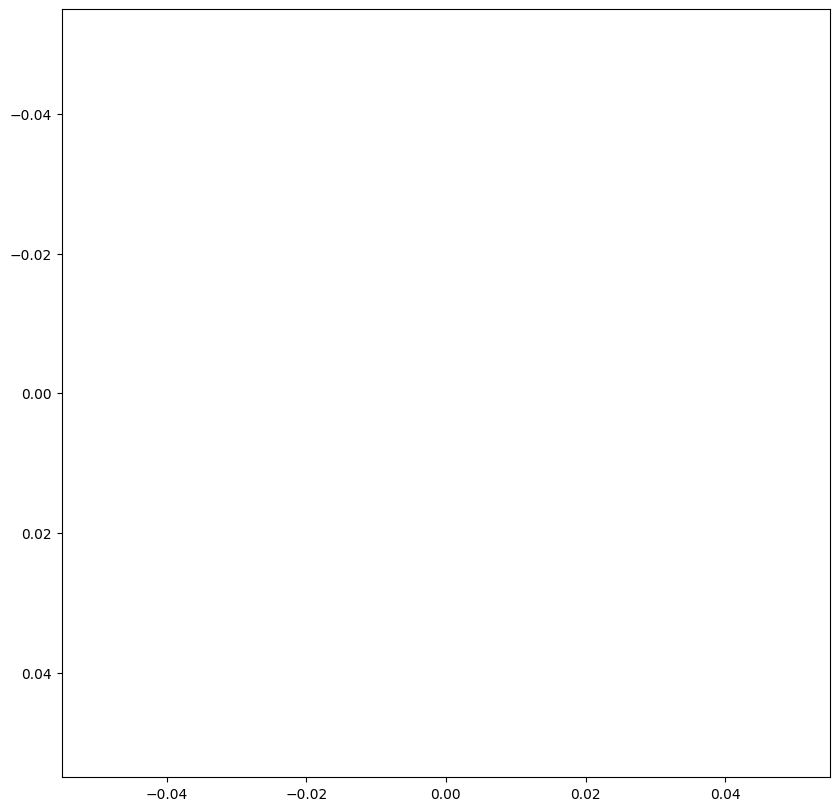

In [17]:
# print(segment_ends[0][0][0][0])
# for point in intersection_points:
    # print(point[0])
# plot_layers_at_cross(layers, intersection_indices, segment_ends)
plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=zoom, cross_index=0, filename=(season + flight + "crossover"))

In [10]:
# twtt 1 = 1.4212416976291829e-05
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[0]
print(f"twtt: {twtt}")

# twtt 2 = 1.395535327834069e-05

# find the depth of both twtt 1 and 2

depth1 = twtt_to_depth(twtt[0], refractive_index=1.77)
print(f"depth1: {depth1}")
depth2 = twtt_to_depth(twtt[1], refractive_index=1.77)
print(f"depth2: {depth2}")

# find the difference in depth
print(f"depth2 - depth1: {depth2 - depth1}")

deltatwtt = twtt[1] - twtt[0]
print(f"deltatwtt: {deltatwtt}")

twtt: [0.0, 0.0]
depth1: 0.0
depth2: 0.0
depth2 - depth1: 0.0
deltatwtt: 0.0


In [ ]:
# repeat the above for every crossover point
flow_xy = [] # the flow vector in xy 
flow_heading_full = [] # the flow vector heading in angle1, angle2, distance (in meters)
flow_heading = []
plane_heading_1 = []
plane_heading_2 = []
angle = [] # the angle between the flow vector and the plane heading
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)
delta_twtt = []

for i in range(len(intersection_indices)):
    # convert the lat-lon point to xy and then to indices
    lat, lon = intersection_points[i] 
    print(f"lat-lon {i}: {lat, lon}")
    
    x, y = latlon_to_xy(lat, lon)
    print(f"x: {x}, y: {y}")
    
    x_index, y_index = x_to_index(x), y_to_index(y)
    print(f"x_index: {x_index}, y_index: {y_index}")
    
    nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)
    
    # find the nearest good iceflow_data to the crossover point
    nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
    nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
    print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")

    flow_xy.append([iceflow_data[2][nearest_x_index][nearest_y_index], iceflow_data[3][nearest_x_index][nearest_y_index]])
    print(f"flow at nearest: {flow_xy[i]}")
    
    # find the heading of the flow vector   
    flow_heading_full.append(xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow_xy[i][0], flow_xy[i][1]))
    flow_heading.append(flow_heading_full[i][0])
    print(f"flow_heading[{i}]: {flow_heading[i]}")
    

    # find the heading of the first segment
    plane_heading_1.append(find_heading(layers[0], intersection_indices[i][0]))
    print(f"heading_1[{i}]: {plane_heading_1[i]}")

    # find the heading of the second segment
    plane_heading_2.append(find_heading(layers[0], intersection_indices[i][1]))
    print(f"heading_2[{i}]: {plane_heading_2[i]}")
    
    # plane_flow_angle = min(abs(plane_heading_1[i] - flow_heading[i]), abs(plane_heading_2[i] - flow_heading[i]))
    plane_flow_angle = max(abs(plane_heading_1[i] - flow_heading[i]), abs(plane_heading_2[i] - flow_heading[i]))

    print(f"plane_flow_angle: {plane_flow_angle}")
    angle.append(plane_flow_angle)
    
    # find the twtt at the crossover point on both segments
    # print(f"twtt{i}: {twtt[i]}")
    # delta_twtt.append(twtt[i][1] - twtt[i][0])
    # append the absolute value of the twtt
    delta_twtt.append(abs(twtt[i][1] - twtt[i][0]))
    print(f"delta_twtt[{i}]: {delta_twtt[i]}")
    
    print(section_break)


length = len(delta_twtt)
while i < length: # remove any nan valued points from the lists
    if math.isnan(delta_twtt[i]):
        delta_twtt.pop(i)
        flow_xy.pop(i)
        angle.pop(i)
        magnitude.pop(i)
        plane_heading_1.pop(i)
        plane_heading_2.pop(i)
        intersection_indices.pop(i)
        intersection_points.pop(i)
        print(f"intersection {i} removed")
        print(section_break)
        length -= 1
    else:
        i += 1
        
# TODO: why is delta_twtt for index 9 negative?
    # it is not, the twtt at the crossover point on the second segment is greater than the twtt at the crossover point on the first segment so that makes sense

In [ ]:
for i in range(len(flow_heading)):
    print(f"flow_heading[{i}]: {flow_heading[i]}")
    print(f"plane_heading_1[{i}]: {plane_heading_1[i]}")
    print(f"plane_heading_2[{i}]: {plane_heading_2[i]}")
    print(f"plane_heading_1 - flow_heading[{i}]: {abs(plane_heading_1[i] - flow_heading[i])}\n")


# TODO: functionize this plot once it works

In [ ]:
# TODO: verify this plot is correct
# TODO: verify the Y scale and label it
    # Dave expects the delta_twtt to be ~0.1 sec
# plot delta_twtt vs |cos(angle - heading) - sin(angle - heading)| * |magnitude|  for each crossover point
plt.figure(figsize=(24, 12), layout='constrained')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 1')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_2)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 2')

# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# cos(angle - heading) vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # flow angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(angle - heading) - sin(angle - heading) |vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(θ) – sin(φ)| vs delta_twtt. theta is the angle between the flow vector and the plane heading on segment 1, phi is the angle between the plane headings on segments 1 and 2
for i in range(len(delta_twtt)):
    theta = angle[i]
    phi = abs(plane_heading_1[i] - plane_heading_2[i])
    print(f"theta: {theta}, phi: {phi} for i: {i}\n cos(theta): {np.cos(np.radians(theta))}, sin(phi): {np.sin(np.radians(phi))}")
    plt.scatter(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), delta_twtt[i], label='segment 1')  # angle - heading   

# for each point, print the index and the delta_twtt
# for i in range(len(delta_twtt)):
#     plt.text(np.abs(np.cos(np.radians(np.array(flow_heading[i]) - np.array(plane_heading_1[i])))), delta_twtt[i], f"{i}: {delta_twtt[i]}")

# plt.xlabel(" |cos(angle - heading)| * |velocity|")
# plt.xlabel(" |cos(angle - heading)|")
plt.xlabel("|cos(θ) – sin(φ)|")

plt.ylabel("delta_twtt (s)")
# plt.title(" |cos(angle - heading)| vs delta_twtt")
# plt.title(f"{season} {flight} \n|cos(angle - heading)| vs delta_twtt", fontsize=20)
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)


plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))
# scale axes to be logarithmic
# plt.xscale('log')
plt.yscale('log')


# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)

# plt.show()

plt.yscale('linear')
# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {season}_{flight}_cos_angle_heading_vs_delta_twtt.png")


# END OF RELEVANT CODE FOR ARA TALK

In [ ]:
# x_data = np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1))))
# y_data = delta_twtt
# 
# # Define the Gaussian function
# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
# 
# # Initial parameter guesses: amplitude close to your data's scale, mean around the center, and a reasonable stddev
# initial_guesses = [1e-8, 0.5, 0.1]
# 
# # Use curve_fit to fit the Gaussian function to your data
# popt, pcov = opt.curve_fit(gaussian, x_data, y_data, p0=initial_guesses, maxfev=5000)
# 
# # Plot the original data
# plt.scatter(x_data, y_data, label='Data')
# 
# # Plot the fitted curve
# x_fit = np.linspace(min(x_data), max(x_data), 1000)
# y_fit = gaussian(x_fit, *popt)
# plt.plot(x_fit, y_fit, color='red', label='Fitted curve')
# 
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Gaussian Fit to Data')
# plt.legend()
# plt.show()

ntuple-ize
    cos(heading-flow)
    difference in theta paralell and perpindicular
    delta_twtt
    v_flow
- stop selecting for angle in upper cells, we can cut the data once we have it

ARA meeting in March Columbus
- talk to Kiet about how he is setting up travel

In [ ]:
heading = []
# for each plane heaading, add [plane_heading_1, plane_heading_2] to the heading list
for i in range(len(plane_heading_1)):
    heading.append([plane_heading_1[i], plane_heading_2[i]])

In [ ]:
print(flow_xy)

In [ ]:
# # save the posit to a json file
# import json
# 
# filename = f"{season}_crossover_data.json"
# 
# # check to see if the file exists and if it does, load the data from it, otherwise append the data to a new file
# try:
#     with open(filename, 'r') as file:
#         data = json.load(file)
#         print(f"File {filename} exists. Loading data from file...")
# except FileNotFoundError:
#     print(f"File {filename} does not exist. Creating a new file...")
#     data = []
#     
# # if the data is not already in the file, append the data to the file
# if data:
#     print(f"Data already in file {filename}.")
# else:
#     print(f"Appending data to file {filename}...")
#     data.append({
#         "season": season,
#         "flight": flight,
#         "intersection_points": intersection_points,
#         "twtt": twtt,
#         "delta_twtt": delta_twtt,
#         "ice flow vectors (m/yr, in xy)": flow,
#         "ice flow angle": angle,
#         "ice flow magnitude": magnitude,
#         "plane heading": heading
#     })
#     with open(filename, 'w') as file:
#         json.dump(data, file)
#     print(f"Data successfully appended to file {filename}.")
# 
# 
# # TODO: convert flow vector and angle to EPSG:4326

### vector to heading dev below, DELETE WHEN FUNCTIONAL

In [ ]:
def nearest_flow_to_latlon(lat, lon, iceflow_data, print_point=False):
    """
    :param lat: the latitude of the point
    :param lon: the longitude of the point
    :param iceflow_data: the iceflow data
    :return: the nearest flow vector to the lat-lon point available in the iceflow data 
    """
    # find the nearest x and y values in the iceflow data
    x, y = latlon_to_xy(lat, lon)
    x, y = find_nearest_unmasked_x_and_y(x, y, iceflow_data, max_radius=1000)
    if print_point:
        print(f"Nearest point to lat-lon: {xyindex_to_latlon(x, y)} or {x, y} in EPSG:3031")
    flow = flow_at_x_y(x, y, iceflow_data)
    return flow

In [ ]:
intersect_x = intersection_points[0][0]
intersect_y = intersection_points[0][1]
print(f"Intersection lat-lon:\n{intersect_x, intersect_y}")
print("----------------------\n")

x, y = latlon_to_xy(intersect_x, intersect_y)
print(f"x, y of intersection before index conversion \nx: {x}, y: {y}\n")

x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"converted to indices:\nx_index: {x_index}, y_index: {y_index}\n")
x_lat, y_lat = xyindex_to_latlon(x_index, y_index)
print(f"lat-lon of indices: \n{x_lat, y_lat}\n")

difference_lat = intersect_x - x_lat
difference_lon = intersect_y - y_lat
print(f"difference in lat-lon: \n{difference_lat, difference_lon}\n")
# So the conversion functions work

### TODO: fix the find nearest functions

In [ ]:
def xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10, printout=False):
    """
    Find the nearest x and y value in the iceflow data to an input x and y value.
    """
    # iterate through every data point within the max_radius of the input x and y and save the xy pairs of any unmasked data
    x = x_to_index(x)
    y = y_to_index(y)
    unmasked = []
    for x_iterator in range(x - max_radius, x + max_radius):
        for y_iterator in range(y - max_radius, y + max_radius):
            if (
                    0 <= x_iterator < iceflow_data[2].shape[0]  # if the x index is within the bounds of the iceflow data
                    and 0 <= y_iterator < iceflow_data[2].shape[1]
                    and not np.ma.is_masked(iceflow_data[2][x_iterator][y_iterator])
                    and not np.ma.is_masked(iceflow_data[3][x_iterator][y_iterator])
            ):
                unmasked.append((x_iterator, y_iterator))
            if printout and not np.ma.is_masked(iceflow_data[2][x_iterator][y_iterator]):
                print(f"unmasked x: {x_iterator}, unmasked y: {y_iterator}")
                print(f"unmasked lat: {iceflow_data[4][x_iterator][y_iterator]}, unmasked lon: {iceflow_data[5][x_iterator][y_iterator]}")
                print(f"unmasked flow: {iceflow_data[2][x_iterator][y_iterator]}, {iceflow_data[3][x_iterator][y_iterator]}")
    # find the xy pair with the minimum distance from the input x and y
    min_distance = 100
    min_x = None
    min_y = None
    for x_iterator, y_iterator in unmasked:
        distance = math.sqrt((x - x_iterator) ** 2 + (y - y_iterator) ** 2)
        if distance < min_distance:
            min_distance = distance
            min_x = x_iterator
            min_y = y_iterator
    # TODO: figure out why these are indices and not x and y
        # it works fine, they just are.
    return min_x, min_y

In [ ]:
lat = intersection_points[0][0]
lon = intersection_points[0][1]
print(f"lat: {lat}, lon: {lon}")

x, y = latlon_to_xy(lat, lon)
print(f"x: {x}, y: {y}")

x_index, y_index = x_to_index(x), y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")

# nearest_x_index, nearest_y_index = depracated: find_nearest_unmasked_x_and_y(x, y, iceflow_data, max_radius=1000)

nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)

print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")
print(f"flow at nearest: {iceflow_data[2][nearest_x_index][nearest_y_index]}, {iceflow_data[3][nearest_x_index][nearest_y_index]}")

In [ ]:
# plot the spiral around the point
plot_spiral(x,y, 10)

### Move to an example notebook when done. Shows how the xy to index conversion works

In [ ]:
#print x min and max
min = np.min(iceflow_data[0])
max = np.max(iceflow_data[0])

print(f"min: {min}, max: {max}")

print(f"min/450: {min/450}, max/450: {max/450}")

one, two, three = (iceflow_data[1][0], iceflow_data[1][1], iceflow_data[1][2])
print(f"one: {one}, two: {two}, three: {three}")
print(f"one - two: {one - two}, two - three: {two - three}")

In [ ]:
def x_to_index(x):
    return 6223 + int(x/450)
def y_to_index(y):
    return 6223 - int(y/450)
def index_to_x(x):
    return (x - 6223) * 450
def index_to_y(y):
    return (6223 - y) * 450

# ~~TODO: see if these are even legal lat-lon values~~
- **they are not but neither are the iceflow data values**
- some of these longitudes don't work in Google Earth, I think they are supposed to be between -180 and 180
- more importantly, are the icflow data and CReSIS lat-lon values in this format (i.e. if they are wrong, stay wrong)

Iceflow data: 
    - max lat: -89.9 - 0 degrees
    - min lat: 0 - 359.79 degrees
    

In [ ]:
x = 6000
y = 1000
print(f"starting values\nx: {x}, y: {y}")
x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")
print(f"x: {iceflow_data[0][x_index]}, y: {iceflow_data[1][y_index]}\n")

x = 9000
y = 5000
print(f"starting values\nx: {x}, y: {y}")
x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")
print(f"x: {iceflow_data[0][x_index]}, y: {iceflow_data[1][y_index]}\n")



In [ ]:
def xyindex_vector_to_heading(x_index, y_index, x_vector, y_vector):
    """
    This function is used to convert an x and y vector in EPSG:3031 to a heading in EPSG:4326.
    :param x_index: the x coordinate
    :param y_index: the y coordinate
    :param x_vector: the x vector
    :param y_vector: the y vector
    :return: the heading in EPSG:4326
    """
    # convert the x and y coordinates to lat and lon
    lat, lon = xyindex_to_latlon(x_index, y_index)
    # convert the x and y vector to lat and lon
    lat_vector, lon_vector = xyindex_to_latlon(x_index + x_vector, y_index + y_vector)
    # calculate the heading
    geodesic = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geodesic.inv(lon, lat, lon_vector, lat_vector)
    return angle1, angle2, distance



# TODO: ~~take some plane vectors, convert the relevant points to xy, then run them through the heading function to see if it works compared to the plane heading~~
- I think this works now

In [ ]:
# for testing purposes only, delete when done
def find_heading_test(lat1, lon1, lat2, lon2):
    # print the lat-lon points
    # print(f"lat-lon input to find_heading:"
    #       f"\n({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    # lon = layer.lon[index]
    # lat = layer.lat[index]
    # lon1 = layer.lon[index - window_size]
    # lat1 = layer.lat[index - window_size]
    # lon2 = layer.lon[index + window_size]
    # lat2 = layer.lat[index + window_size]

    print(f"lat-lons determined by find_heading:"
          f"\n({lat1}, {lon1}), ({lat2}, {lon2})")
    # delta_lon1 = lon - lon1
    # delta_lat1 = lat - lat1
    # delta_lon2 = lon2 - lon
    # delta_lat2 = lat2 - lat
    # print(f"delta_lon1: {delta_lon1}, delta_lat1: {delta_lat1}, delta_lon2: {delta_lon2}, delta_lat2: {delta_lat2}")
    fwd_azimuth, back_azimuth, distance = geodesic.inv(lon1, lat1, lon2, lat2)
    return fwd_azimuth

In [ ]:
def find_heading_points(layer, index, window_size=100):
    """
    :param layer: a Layer object
    :param index: the index of the point in the layer
    :param window_size: the number of points to use in the slope calculation
    :return: the bearing of the current that flew through the points.
    This has nothing to do with the slope of the layer. only the lat-lon points.
    """
    # print the lat-lon points
    print(f"lat-lon input to find_heading:"
          f"\n\t({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    lon = layer.lon[index]
    lat = layer.lat[index]
    lon1 = layer.lon[index - window_size]
    lat1 = layer.lat[index - window_size]
    lon2 = layer.lon[index + window_size]
    lat2 = layer.lat[index + window_size]
    
    return lon1, lat1, lon2, lat2

In [ ]:
# TODO: when this works, udpate the original code cell to use the non test versions of the iceflow heading function
# TODO, the iceflow heading finder doesn't work on too close of data because they show up as the same index in the iceflow data.
    # put in some larger fake lat-lons to test both
    # how was it working before then?
        # the flow vector comes from the data so it works
magnitude = []
plane_heading_1 = []
plane_heading_2 = []
# for i in range(len(intersection_indices)):
for i in range(1):
    # find the heading of the first segment
    test_lat1 = -81.1 
    test_lon1 = -29.7
    test_lat2 = -81.2
    test_lon2 = -29.8
    plane_heading_1.append(find_heading_test(test_lat1, test_lon1, test_lat2, test_lon2))
    print(f"heading_1[{i}]: {plane_heading_1[i]}")
    
    print("**************")

    # convert the test lat-lon points to xy
    x1, y1 = latlon_to_xy(test_lat1, test_lon1) 
    x2, y2 = latlon_to_xy(test_lat2, test_lon2)
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    
    # convert the xy points to indices
    x1_index = x_to_index(x1)
    y1_index = y_to_index(y1)
    x2_index = x_to_index(x2)
    y2_index = y_to_index(y2)
    print(f"x1_index: {x1_index}, y1_index: {y1_index}, x2_index: {x2_index}, y2_index: {y2_index}")
    
    # TODO: should this be a vector of indices or x and y? x and y sounds right but it errors out on index overflow. Have to go to class so can't look right now. Does the xy_vector function use indices or x and y? 
        # the vector_to_heading() function uses indices for some reason but it works so I'mma let it ride
    vector = [x2_index - x1_index, y2_index - y1_index]
    # vector = [x2 - x1, y2 - y1]

    # convert the vector to a heading
    heading = xyindex_vector_to_heading(x1_index, y1_index, vector[0], vector[1])
    
    print(f"heading by way of iceflow functions: \n{heading}")
    
    
    
    print(section_break)
    
    


In [ ]:
# calculate the twtt to depth conversion for 10, 20, ..., 100 microseconds

twtt = np.arange(10, 110, 10) * 1e-6
depth = twtt_to_depth(twtt, refractive_index=1.77)

# for each twtt, print the twtt in microseconds and the depth in meters. both should be rounded to 0 decimal places
print(f"twtt to depth conversion for refractive index 1.77:")
for i in range(len(twtt)):
    print(f"{twtt[i] * 1e6:.0f} {chr(956)}s:\t{depth[i]:.0f} meters")